# <font color='blue'>Forecasting Hospital Expenses</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline

In [2]:
expenses = pd.read_csv('despesas.csv')
expenses.head()

,idade,sexo,bmi,filhos,fumante,regiao,gastos
0,19,mulher,27.9,0,sim,sudeste,16884.92
1,18,homem,33.8,1,nao,sul,1725.55
2,28,homem,33.0,3,nao,sul,4449.46
3,33,homem,22.7,0,nao,nordeste,21984.47
4,32,homem,28.9,0,nao,nordeste,3866.86


In [3]:
expenses.describe()

,idade,bmi,filhos,gastos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [4]:
gender = {'homem':0, 'mulher':1}
smoker = {'nao':0, 'sim':1}
area = {'sudeste':0, 'sul':1, 'centro-oeste':2, 'nordeste':3, 'norte':4}

expenses['sexo'] = expenses['sexo'].map(gender)
expenses['fumante'] = expenses['fumante'].map(smoker)
expenses['regiao'] = expenses['regiao'].map(area)

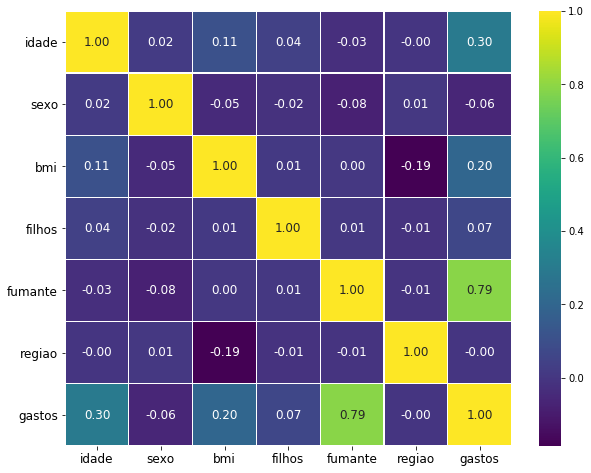

In [5]:
# Calculates the correlation and plot the data in s heatmap
sns.heatmap(expenses.corr(), annot = True, cmap = 'viridis', linewidths = 0.2, annot_kws = {'size':12}, fmt = '.2f')
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

In [6]:
# Creating new variables to try to enrich the model
expenses['bmi_over_30'] = expenses['bmi'].apply(lambda x: 1 if x > 30 else 0)
expenses['age'] = expenses['idade'].apply(lambda x: np.square(x))

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, Normalizer

select = [c for c in expenses.columns if c not in ['gastos','sexo','fumante', 'regiao','bmi_over_30']]
    
scaler_x = StandardScaler()
normal_x = Normalizer()

scaler_y = StandardScaler()
normal_y = Normalizer()

df_normalized = pd.DataFrame(scaler_x.fit_transform(expenses[select]))
df_transformed = pd.DataFrame(normal_x.fit_transform(df_normalized))
df_transformed.columns = select
expenses[select] = df_transformed

expenses['gastos'] = pd.DataFrame(scaler_y.fit_transform(np.array(expenses['gastos']).reshape(-1,1)))

/Users/Daniela/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Daniela/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
le = LabelEncoder()
for col in ['sexo','fumante', 'regiao', 'bmi_over_30']:
    expenses[col] = le.fit_transform(expenses[col])
#expenses = pd.get_dummies(expenses, columns = ['regiao']) ## worsens the model

In [9]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = [c for c in expenses.columns if c not in ['gastos', 'regiao']]

X_train, X_test, y_train, y_test = train_test_split(expenses[features], expenses['gastos'], test_size = 0.2, random_state = 42)

rf = RandomForestRegressor(random_state = 42)

model_rf = rf.fit(X_train, y_train)
prediction = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, prediction)
mae_rf = mean_absolute_error(y_test, prediction)

print('Random Forest Regressor performance on the test set: MAE = {0:0.4f}' .format(mae_rf))
print('Random Forest Regressor performance on the test set: MSE = {0:0.4f}\n' .format(mse_rf))

gbr = GradientBoostingRegressor(random_state = 42)

model_gb = gbr.fit(X_train, y_train)
prediction = model_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, prediction)
mae_gb = mean_absolute_error(y_test, prediction)
print('Gradient Boosted Regressor performance on the test set: MAE = {0:0.4f}' .format(mae_gb))
print('Gradient Boosted Regressor performance on the test set: MSE = {0:0.4f}' .format(mse_gb))

/Users/Daniela/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regressor performance on the test set: MAE = 0.1945
Random Forest Regressor performance on the test set: MSE = 0.1433

Gradient Boosted Regressor performance on the test set: MAE = 0.1991
Gradient Boosted Regressor performance on the test set: MSE = 0.1328


In [10]:
# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': ['lad', 'huber'],
                       'n_estimators':[10, 100, 500, 1000, 1500],
                       'learning_rate': [0.01, 0.05, 0.1, 0.3],
                       'max_depth': [3, 5, 10],
                       'min_samples_leaf': [0.1, 0.5, 1, 3, 5, 10, 15],
                       'min_samples_split': [3, 5, 10, 15],
                       'max_features': ['auto', 'sqrt']
                      }
number_cv, number_iter = 2, 25

def model(hyperparameter_grid, number_cv, number_iter):


    # Create the model to use for hyperparameter tuning
    model = GradientBoostingRegressor(random_state = 42)

    # Set up the random search with 2-fold cross validation
    random_cv = RandomizedSearchCV(estimator=model, param_distributions=hyperparameter_grid,
                               cv= number_cv, n_iter= number_iter, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state = 42)

    # Fit on the training data
    random_cv.fit(X_train, y_train)

    return random_cv.best_estimator_
model = model(hyperparameter_grid, number_cv, number_iter)
print(model)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.0s finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [11]:
prediction = model.predict(X_test)

mse_gb = mean_squared_error(y_test, prediction)
mae_gb = mean_absolute_error(y_test, prediction)
print('Gradient Boosted Regressor performance on the test set: MAE = {0:0.4f}' .format(mae_gb))
print('Gradient Boosted Regressor performance on the test set: MSE = {0:0.4f}' .format(mse_gb))

Gradient Boosted Regressor performance on the test set: MAE = 0.1377
Gradient Boosted Regressor performance on the test set: MSE = 0.1321


In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

gradient_boosted=GradientBoostingRegressor(loss ='lad', 
                            n_estimators = 1500,
                            learning_rate = 0.3,
                            max_depth = 5,
                            max_features = 'auto',
                            min_samples_leaf = 0.1,
                            min_samples_split = 10,
                            random_state = 42
                          )

gradient_boosted.fit(X_train, y_train)
prediction = np.array(gradient_boosted.predict(X_test)).reshape(-1,1)

mse_gb = mean_squared_error(y_test, prediction)
mae_gb = mean_absolute_error(y_test, prediction)
print('Gradient Boosted Regressor performance on the test set: MAE = {0:0.4f}' .format(mae_gb))
print('Gradient Boosted Regressor performance on the test set: MSE = {0:0.4f}' .format(mse_gb))

Gradient Boosted Regressor performance on the test set: MAE = 0.1510
Gradient Boosted Regressor performance on the test set: MSE = 0.1336


Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.2s finished


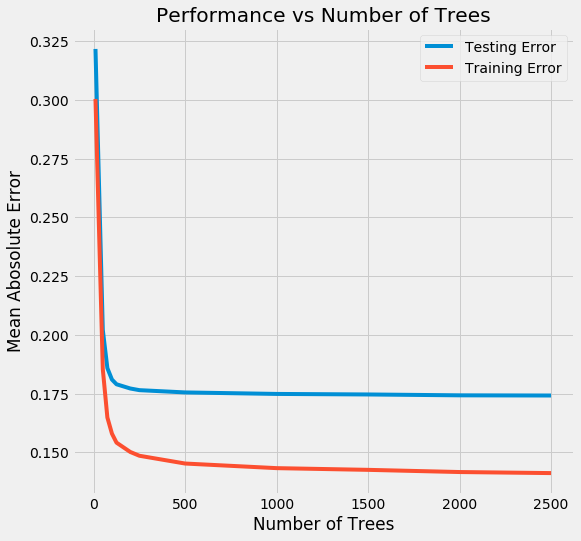

In [13]:
n_estimators_grid = {'n_estimators':[10, 50, 75, 100, 125, 200, 250, 500, 1000, 1500, 2000, 2500]}

gradient_boosted = GradientBoostingRegressor(loss='lad', 
                            #n_estimators = 1500,
                            learning_rate = 0.3,
                            max_depth = 5,
                            max_features = 'auto',
                            min_samples_leaf = 0.1,
                            min_samples_split = 10,
                            random_state = 42
                          )

grid_search = GridSearchCV(estimator = gradient_boosted, 
                           param_grid = n_estimators_grid, 
                           cv = 2, 
                           scoring = 'neg_mean_absolute_error', 
                           verbose = 1,
                           n_jobs = -1, 
                           return_train_score = True)

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [14]:
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
final_predictions = np.array(final_model.predict(X_test)).reshape(-1,1)

mse_gb = mean_squared_error(y_test, final_predictions)
mae_gb = mean_absolute_error(y_test, final_predictions)
print('Gradient Boosted Regressor performance on the test set: MAE = {0:0.4f}' .format(mae_gb))
print('Gradient Boosted Regressor performance on the test set: MSE = {0:0.4f}' .format(mse_gb))

Gradient Boosted Regressor performance on the test set: MAE = 0.1500
Gradient Boosted Regressor performance on the test set: MSE = 0.1333
